In [38]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANDL/Homework_1


In [9]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [10]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [11]:
# Dataset folders 
dataset_dir = 'atMost300'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

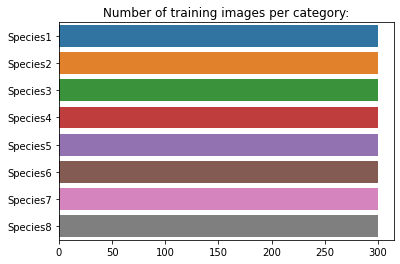

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(preprocess_input,
                            rotation_range=180,
                            
                            #cut add reflex
                            zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True, 
                            fill_mode='reflect',
                            cval=0) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [14]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 2400 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [15]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


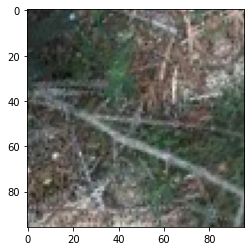

In [16]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [17]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

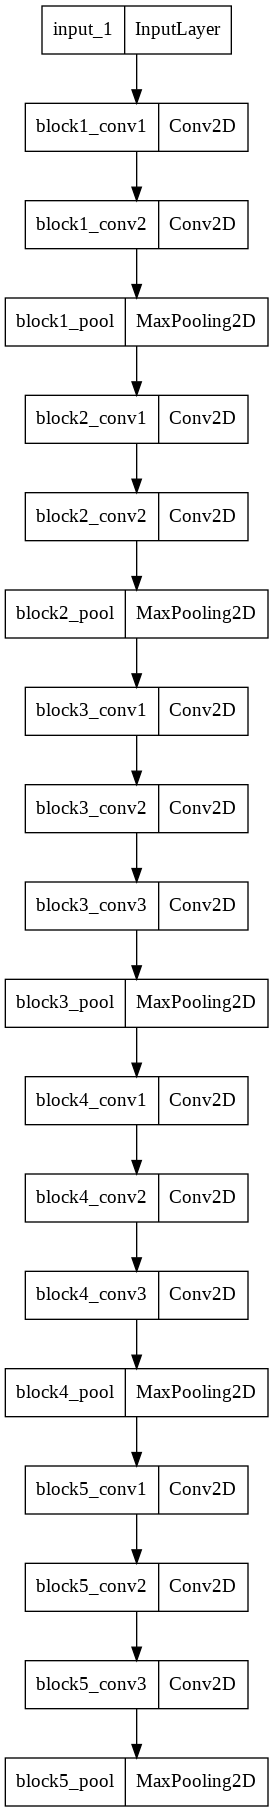

In [18]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [19]:
input_shape = (96, 96, 3)
epochs = 200

In [20]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [21]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [22]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
75/75 [==============================] - ETA: 0s - loss: 5.7233 - accuracy: 0.3192 - precision: 0.3399 - recall: 0.2783 

75/75 [==============================] - 1452s 19s/step - loss: 5.7233 - accuracy: 0.3192 - precision: 0.3399 - recall: 0.2783 - val_loss: 1.8211 - val_accuracy: 0.3681 - val_precision: 0.4886 - val_recall: 0.1632
Epoch 2/200
 1/75 [..............................] - ETA: 16s - loss: 1.6440 - accuracy: 0.3750 - precision: 0.5000 - recall: 0.2500

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.8697 - accuracy: 0.3446 - precision: 0.4849 - recall: 0.1808

75/75 [==============================] - 16s 217ms/step - loss: 1.8697 - accuracy: 0.3446 - precision: 0.4849 - recall: 0.1808 - val_loss: 1.7033 - val_accuracy: 0.3814 - val_precision: 0.5000 - val_recall: 0.1765
Epoch 3/200
 1/75 [..............................] - ETA: 11s - loss: 1.5859 - accuracy: 0.4375 - precision: 0.5000 - recall: 0.1562

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.6430 - accuracy: 0.3938 - precision: 0.5547 - recall: 0.2175

75/75 [==============================] - 15s 201ms/step - loss: 1.6430 - accuracy: 0.3938 - precision: 0.5547 - recall: 0.2175 - val_loss: 1.8051 - val_accuracy: 0.3757 - val_precision: 0.4712 - val_recall: 0.2486
Epoch 4/200
 1/75 [..............................] - ETA: 11s - loss: 1.4091 - accuracy: 0.4375 - precision: 0.5833 - recall: 0.2188

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.5483 - accuracy: 0.4283 - precision: 0.5670 - recall: 0.2346

75/75 [==============================] - 15s 204ms/step - loss: 1.5483 - accuracy: 0.4283 - precision: 0.5670 - recall: 0.2346 - val_loss: 1.8369 - val_accuracy: 0.3947 - val_precision: 0.4710 - val_recall: 0.2619
Epoch 5/200
 1/75 [..............................] - ETA: 11s - loss: 2.0082 - accuracy: 0.3438 - precision: 0.5385 - recall: 0.2188

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.5084 - accuracy: 0.4512 - precision: 0.6002 - recall: 0.2783

75/75 [==============================] - 16s 213ms/step - loss: 1.5084 - accuracy: 0.4512 - precision: 0.6002 - recall: 0.2783 - val_loss: 1.7485 - val_accuracy: 0.3681 - val_precision: 0.4667 - val_recall: 0.2524
Epoch 6/200
 1/75 [..............................] - ETA: 12s - loss: 1.0843 - accuracy: 0.6562 - precision: 0.6154 - recall: 0.2500

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.4199 - accuracy: 0.4783 - precision: 0.6373 - recall: 0.2862

75/75 [==============================] - 15s 204ms/step - loss: 1.4199 - accuracy: 0.4783 - precision: 0.6373 - recall: 0.2862 - val_loss: 1.7406 - val_accuracy: 0.3947 - val_precision: 0.4938 - val_recall: 0.3036
Epoch 7/200
 1/75 [..............................] - ETA: 11s - loss: 2.0175 - accuracy: 0.2812 - precision: 0.2778 - recall: 0.1562

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.4362 - accuracy: 0.4733 - precision: 0.6326 - recall: 0.2912

75/75 [==============================] - 15s 201ms/step - loss: 1.4362 - accuracy: 0.4733 - precision: 0.6326 - recall: 0.2912 - val_loss: 1.8633 - val_accuracy: 0.3985 - val_precision: 0.4665 - val_recall: 0.2770
Epoch 8/200
 1/75 [..............................] - ETA: 11s - loss: 1.2314 - accuracy: 0.5938 - precision: 0.7857 - recall: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.3415 - accuracy: 0.5058 - precision: 0.6589 - recall: 0.3300

75/75 [==============================] - 15s 205ms/step - loss: 1.3415 - accuracy: 0.5058 - precision: 0.6589 - recall: 0.3300 - val_loss: 1.7627 - val_accuracy: 0.3985 - val_precision: 0.4753 - val_recall: 0.2922
Epoch 9/200
 1/75 [..............................] - ETA: 11s - loss: 1.3011 - accuracy: 0.5000 - precision: 0.6923 - recall: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2819 - accuracy: 0.5129 - precision: 0.6731 - recall: 0.3483

75/75 [==============================] - 16s 217ms/step - loss: 1.2819 - accuracy: 0.5129 - precision: 0.6731 - recall: 0.3483 - val_loss: 1.8728 - val_accuracy: 0.3795 - val_precision: 0.4721 - val_recall: 0.3207
Epoch 10/200
 1/75 [..............................] - ETA: 11s - loss: 1.1162 - accuracy: 0.5625 - precision: 0.7200 - recall: 0.5625

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.3368 - accuracy: 0.5229 - precision: 0.6448 - recall: 0.3358

75/75 [==============================] - 15s 204ms/step - loss: 1.3368 - accuracy: 0.5229 - precision: 0.6448 - recall: 0.3358 - val_loss: 1.9583 - val_accuracy: 0.3719 - val_precision: 0.4657 - val_recall: 0.2960
Epoch 11/200
 1/75 [..............................] - ETA: 11s - loss: 1.4277 - accuracy: 0.4062 - precision: 0.5000 - recall: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2812 - accuracy: 0.5204 - precision: 0.6592 - recall: 0.3433

75/75 [==============================] - 15s 202ms/step - loss: 1.2812 - accuracy: 0.5204 - precision: 0.6592 - recall: 0.3433 - val_loss: 2.0313 - val_accuracy: 0.4194 - val_precision: 0.5000 - val_recall: 0.3510
Epoch 12/200
 1/75 [..............................] - ETA: 11s - loss: 1.5574 - accuracy: 0.4062 - precision: 0.4706 - recall: 0.2500

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.5263 - precision: 0.6840 - recall: 0.3679

75/75 [==============================] - 15s 203ms/step - loss: 1.2575 - accuracy: 0.5263 - precision: 0.6840 - recall: 0.3679 - val_loss: 1.8717 - val_accuracy: 0.4023 - val_precision: 0.4747 - val_recall: 0.3378
Epoch 13/200
 1/75 [..............................] - ETA: 11s - loss: 1.3886 - accuracy: 0.4062 - precision: 0.7273 - recall: 0.2500

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2609 - accuracy: 0.5192 - precision: 0.6687 - recall: 0.3642

75/75 [==============================] - 16s 213ms/step - loss: 1.2609 - accuracy: 0.5192 - precision: 0.6687 - recall: 0.3642 - val_loss: 2.0032 - val_accuracy: 0.3928 - val_precision: 0.4677 - val_recall: 0.3302
Epoch 14/200
 1/75 [..............................] - ETA: 11s - loss: 1.4021 - accuracy: 0.5625 - precision: 0.6250 - recall: 0.3125

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2850 - accuracy: 0.5158 - precision: 0.6559 - recall: 0.3462

75/75 [==============================] - 15s 201ms/step - loss: 1.2850 - accuracy: 0.5158 - precision: 0.6559 - recall: 0.3462 - val_loss: 1.9196 - val_accuracy: 0.3966 - val_precision: 0.4984 - val_recall: 0.2979
Epoch 15/200
 1/75 [..............................] - ETA: 11s - loss: 1.3258 - accuracy: 0.5312 - precision: 0.6000 - recall: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2729 - accuracy: 0.5383 - precision: 0.6793 - recall: 0.3671

75/75 [==============================] - 15s 203ms/step - loss: 1.2729 - accuracy: 0.5383 - precision: 0.6793 - recall: 0.3671 - val_loss: 2.1220 - val_accuracy: 0.3852 - val_precision: 0.4536 - val_recall: 0.3150
Epoch 16/200
 1/75 [..............................] - ETA: 11s - loss: 1.2575 - accuracy: 0.4062 - precision: 0.6429 - recall: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2395 - accuracy: 0.5346 - precision: 0.6880 - recall: 0.3767

75/75 [==============================] - 15s 200ms/step - loss: 1.2395 - accuracy: 0.5346 - precision: 0.6880 - recall: 0.3767 - val_loss: 2.0422 - val_accuracy: 0.4042 - val_precision: 0.4820 - val_recall: 0.3055
Epoch 17/200
 1/75 [..............................] - ETA: 11s - loss: 1.0023 - accuracy: 0.5625 - precision: 0.6190 - recall: 0.4062

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.2000 - accuracy: 0.5629 - precision: 0.7013 - recall: 0.3963

75/75 [==============================] - 16s 218ms/step - loss: 1.2000 - accuracy: 0.5629 - precision: 0.7013 - recall: 0.3963 - val_loss: 2.0905 - val_accuracy: 0.3890 - val_precision: 0.4578 - val_recall: 0.3188
Epoch 18/200
 1/75 [..............................] - ETA: 12s - loss: 0.9848 - accuracy: 0.6875 - precision: 0.8421 - recall: 0.5000

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.1951 - accuracy: 0.5646 - precision: 0.7140 - recall: 0.3942

75/75 [==============================] - 15s 201ms/step - loss: 1.1951 - accuracy: 0.5646 - precision: 0.7140 - recall: 0.3942 - val_loss: 2.2218 - val_accuracy: 0.3833 - val_precision: 0.4519 - val_recall: 0.3302
Epoch 19/200
 1/75 [..............................] - ETA: 12s - loss: 1.2489 - accuracy: 0.5000 - precision: 0.6000 - recall: 0.3750

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.1673 - accuracy: 0.5663 - precision: 0.7194 - recall: 0.4167

75/75 [==============================] - 15s 205ms/step - loss: 1.1673 - accuracy: 0.5663 - precision: 0.7194 - recall: 0.4167 - val_loss: 2.0749 - val_accuracy: 0.3909 - val_precision: 0.4615 - val_recall: 0.3302
Epoch 20/200
 1/75 [..............................] - ETA: 11s - loss: 0.8791 - accuracy: 0.7812 - precision: 1.0000 - recall: 0.5000

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.1562 - accuracy: 0.5763 - precision: 0.7117 - recall: 0.4196

75/75 [==============================] - 15s 200ms/step - loss: 1.1562 - accuracy: 0.5763 - precision: 0.7117 - recall: 0.4196 - val_loss: 2.0777 - val_accuracy: 0.4175 - val_precision: 0.4675 - val_recall: 0.3548
Epoch 21/200
 1/75 [..............................] - ETA: 12s - loss: 1.1411 - accuracy: 0.5938 - precision: 0.7500 - recall: 0.3750

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - ETA: 0s - loss: 1.1695 - accuracy: 0.5683 - precision: 0.6834 - recall: 0.4137

75/75 [==============================] - 17s 221ms/step - loss: 1.1695 - accuracy: 0.5683 - precision: 0.6834 - recall: 0.4137 - val_loss: 2.0254 - val_accuracy: 0.3890 - val_precision: 0.4397 - val_recall: 0.3112


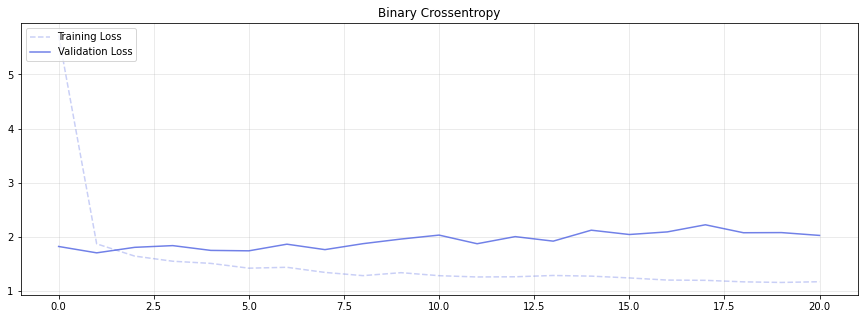

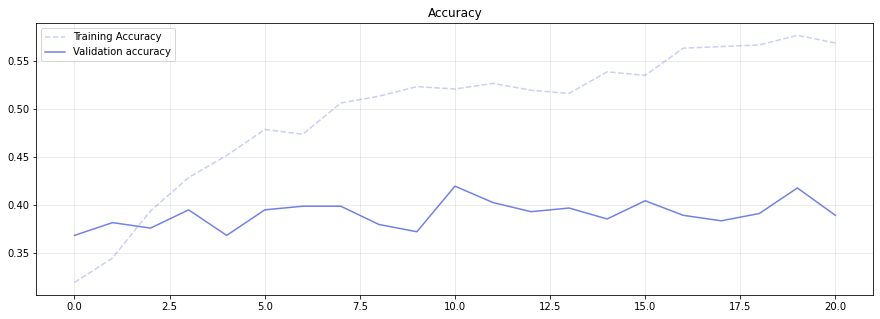

In [23]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [32]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [33]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [34]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [35]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [36]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [39]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


75/75 [==============================] - 14s 162ms/step - loss: 1.4457 - accuracy: 0.4688 - precision_2: 0.6114 - recall_2: 0.2937 - val_loss: 1.8309 - val_accuracy: 0.3890 - val_precision_2: 0.4500 - val_recall_2: 0.2903
Epoch 2/200
75/75 [==============================] - 10s 137ms/step - loss: 1.2414 - accuracy: 0.5371 - precision_2: 0.6992 - recall_2: 0.3729 - val_loss: 1.6765 - val_accuracy: 0.4877 - val_precision_2: 0.5629 - val_recall_2: 0.3226
Epoch 3/200
75/75 [==============================] - 10s 137ms/step - loss: 1.1528 - accuracy: 0.5763 - precision_2: 0.7146 - recall_2: 0.4308 - val_loss: 1.5240 - val_accuracy: 0.4820 - val_precision_2: 0.5508 - val_recall_2: 0.3909
Epoch 4/200
75/75 [==============================] - 10s 138ms/step - loss: 1.0818 - accuracy: 0.6050 - precision_2: 0.7172 - recall_2: 0.4533 - val_loss: 1.5369 - val_accuracy: 0.5123 - val_precision_2: 0.6140 - val_recall_2: 0.3985
Epoch 5/200
75/75 [==============================] - 10s 137ms/step - loss: 

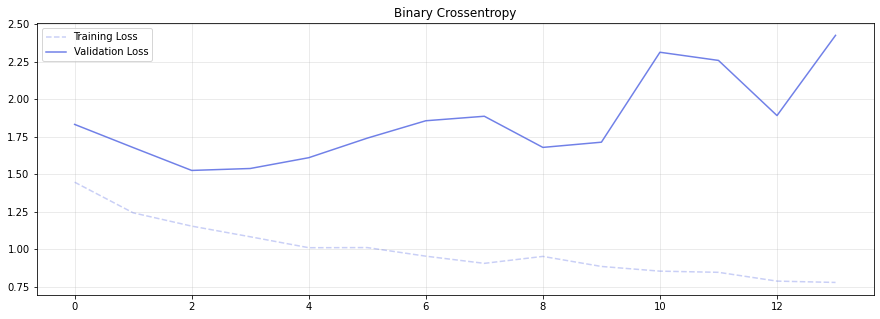

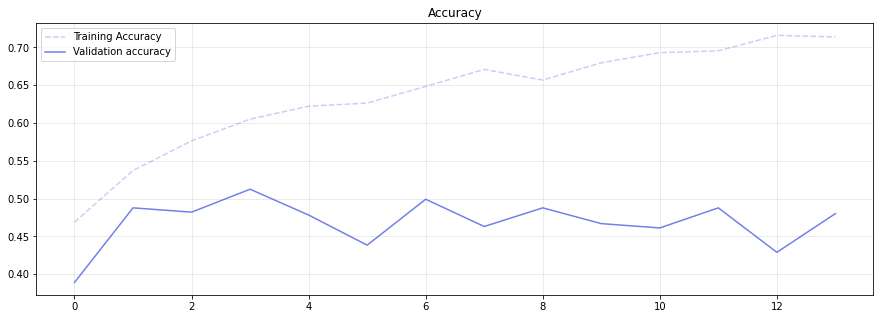

In [40]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [41]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [42]:
tl_model.save('Vgg16/Tuned_v1_1')

In [43]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 189s 17s/step - loss: 1.4868 - accuracy: 0.4820 - precision_2: 0.5917 - recall_2: 0.3573

Test metrics
{'loss': 1.4867703914642334, 'accuracy': 0.4819944500923157, 'precision_2': 0.5917431116104126, 'recall_2': 0.3573407232761383}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.482
Precision: 0.6109
Recall: 0.4652
F1: 0.4451


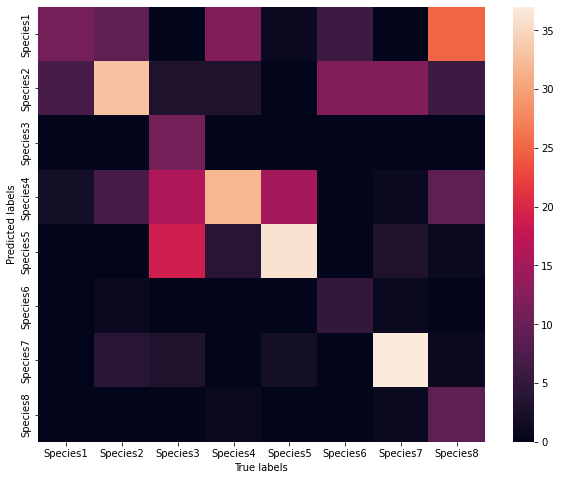

In [44]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()